### Imports

In [1]:
import pandas as pd
import json
import os, sys
from tqdm import tqdm
import numpy as np
import polars as pl
from polars import col as c
from pprint import pprint
import matplotlib.pyplot as plt
import re
import shap
import pickle

sys.path.append("../")
pl.Config.set_tbl_rows(50)

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa

# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, CatBoostClassifier
import optuna
from sklearn.ensemble import RandomForestClassifier

/Users/konstantinburkin/Documents/hse_projects/parse-records/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### constants

In [2]:
FILES_DIR = "../data"

### select data

In [3]:
# os.path.join(FILES_DIR, path)

In [4]:
path = "data_for_models"
os.makedirs(os.path.join(FILES_DIR, path), exist_ok=True)
file_name = "imputed_labeled_data.parquet"
file_path = os.path.join(FILES_DIR, path, file_name)
labeled_data = pl.read_parquet(file_path)

with open(
    os.path.join(os.path.join(FILES_DIR, path), "numerical_cols.pickle"), "rb"
) as f:
    numerical_cols = pickle.load(f)

with open(
    os.path.join(os.path.join(FILES_DIR, path), "discrete_cols.pickle"), "rb"
) as f:
    discrete_cols = pickle.load(f)

In [5]:
labeled_data["target"].value_counts().sort("count")

target,count
i32,u32
1,473
0,518
-1,6289


In [6]:
labeled_data.sample(2)

admission_datetime,gender,patient_id,gospitalisation_type,gospitalisation_delivery,target,final_table1_main_desease_status,final_table1_gospitalization_result,condition_status,full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ejection_fraction,full_wards_ecg_ventricular_septal,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_age,full_wards_ecg_heart_rate,main_disease_I21,main_disease_I20,disease_K29,disease_I83,disease_I49,disease_I48,disease_K86,disease_U07,disease_D50,disease_I70,disease_J42,disease_N28,disease_I45,disease_I35,disease_N40,disease_E06,disease_E66,disease_J44,disease_I11,disease_I67,disease_E04,disease_K25,disease_I69,disease_B18,disease_J45,disease_E11,disease_G93,disease_C34,disease_I34,disease_I25,disease_I63,disease_E03,disease_K80,disease_E74,disease_E10,disease_L40,disease_I50,disease_H90,disease_M42,disease_D64,disease_N20,disease_M10,disease_I44,disease_C50,disease_I71,disease_I64,disease_N18,disease_K26,disease_C61,disease_C18,disease_I47,bmi
datetime[ms],i64,str,i64,i64,i32,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64
2024-06-25 00:00:00,1,"""7AA35C2C-1072-4A6F-A35C-2C1072…",0,1,-1,2,0,2,3.1,3.5,2.7,124.0,51.0,73.0,44.0,1.1,3.0,0.0,48.0,96.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25.0
2019-03-25 00:00:00,1,"""5AEE462F-5EA3-4E4B-887E-932E96…",0,0,0,2,0,0,3.3,3.4,2.9,125.0,65.0,60.0,48.0,1.2,3.4,0.5,64.0,75.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28.430796


## model with known target

### split data

In [7]:
known_target = labeled_data.filter(c("target") != -1)

In [8]:
discrete_cols_without_main_disease = list(
    set(discrete_cols) - set(["main_disease_I21"])
)

In [9]:
# sorted(discrete_cols_without_main_disease)

discrete_cols_cut = [
    "condition_status",
    "final_table1_gospitalization_result",
    "final_table1_main_desease_status",
    "gender",
    "gospitalisation_delivery",
    "gospitalisation_type",
    "main_disease_I21",
]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    known_target.select(discrete_cols_cut + numerical_cols),
    known_target["target"],
    test_size=0.2,
    random_state=2,
)

X_train_cut, X_eval, y_train_cut, y_eval = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=1,
)  # 0.25 x 0.8 = 0.2

In [11]:
# cat_cols = X_train.select(
#     pl.selectors.by_dtype(pl.String),
# ).columns

### catboost

In [12]:
model = CatBoostClassifier(
    random_seed=2024,
    cat_features=discrete_cols_cut,
    eval_metric="AUC",
    depth=3,
    iterations=250,
    learning_rate=0.06,
)

model.fit(
    X=X_train.to_pandas(),
    y=y_train.to_pandas(),
    early_stopping_rounds=50,
    verbose=5,
    eval_set=(
        X_eval.to_pandas(),
        y_eval.to_pandas(),
    ),
)

metric = roc_auc_score(y_test, model.predict_proba(X_test.to_pandas())[:, 1])
print(f"AUC Score (Random Forest): {metric:.3f}")

0:	test: 0.6803657	best: 0.6803657 (0)	total: 57.4ms	remaining: 14.3s
5:	test: 0.7508744	best: 0.7508744 (5)	total: 62.9ms	remaining: 2.56s
10:	test: 0.7521463	best: 0.7529412 (6)	total: 67.6ms	remaining: 1.47s
15:	test: 0.7581081	best: 0.7581081 (15)	total: 72.3ms	remaining: 1.06s
20:	test: 0.7582671	best: 0.7615262 (19)	total: 77.1ms	remaining: 841ms
25:	test: 0.7613672	best: 0.7615262 (19)	total: 82.3ms	remaining: 709ms
30:	test: 0.7650238	best: 0.7650238 (30)	total: 87.2ms	remaining: 616ms
35:	test: 0.7731320	best: 0.7739269 (34)	total: 93.4ms	remaining: 555ms
40:	test: 0.7758347	best: 0.7761526 (37)	total: 98.5ms	remaining: 502ms
45:	test: 0.7812401	best: 0.7812401 (45)	total: 103ms	remaining: 459ms
50:	test: 0.7823529	best: 0.7831479 (49)	total: 108ms	remaining: 422ms
55:	test: 0.7877583	best: 0.7877583 (55)	total: 113ms	remaining: 392ms
60:	test: 0.7920509	best: 0.7920509 (60)	total: 118ms	remaining: 366ms
65:	test: 0.7955485	best: 0.7955485 (65)	total: 124ms	remaining: 345ms
70

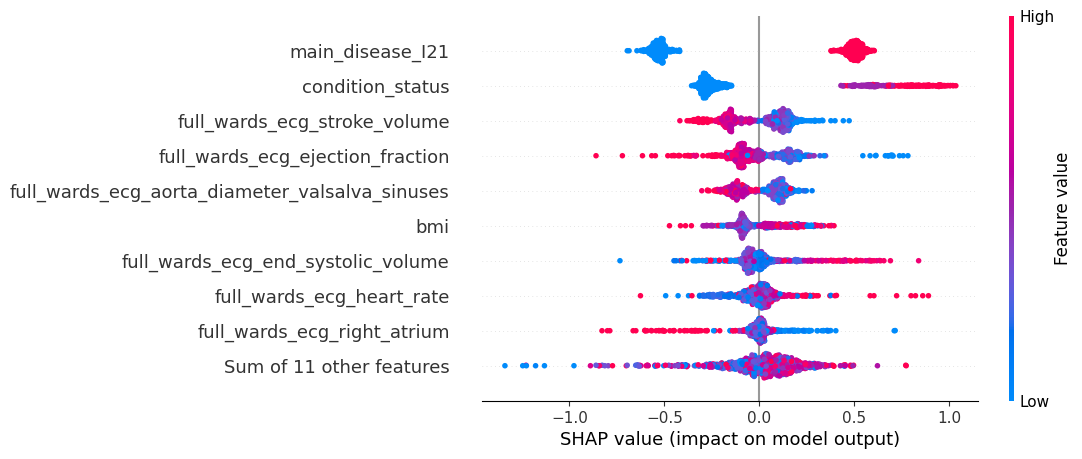

In [13]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train.to_pandas())
shap.plots.beeswarm(
    shap_values,
    plot_size=(8, 5),
)
plt.show()

In [28]:
X_train.columns

['condition_status',
 'final_table1_gospitalization_result',
 'final_table1_main_desease_status',
 'gender',
 'gospitalisation_delivery',
 'gospitalisation_type',
 'main_disease_I21',
 'full_wards_ecg_right_atrium',
 'full_wards_ecg_left_atrium',
 'full_wards_ecg_right_ventricle',
 'full_wards_ecg_end_diastolic_volume',
 'full_wards_ecg_end_systolic_volume',
 'full_wards_ecg_stroke_volume',
 'full_wards_ecg_ventricular_septal',
 'full_wards_ecg_aorta_diameter_valsalva_sinuses',
 'full_wards_ecg_age',
 'full_wards_ecg_heart_rate',
 'full_wards_ecg_ascending_aorta',
 'full_wards_ecg_ejection_fraction',
 'bmi']

In [32]:
X_train["main_disease_I21"].to_pandas().dtype

dtype('int64')

In [41]:
X_test[0]["main_disease_I21"]
# .astype(X_train["main_disease_I21"].to_pandas().dtype)

main_disease_I21
i64
1


/var/folders/yt/5rqq39t16xs0vjb7z99vs0cw0000gn/T/ipykernel_77485/1551176968.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


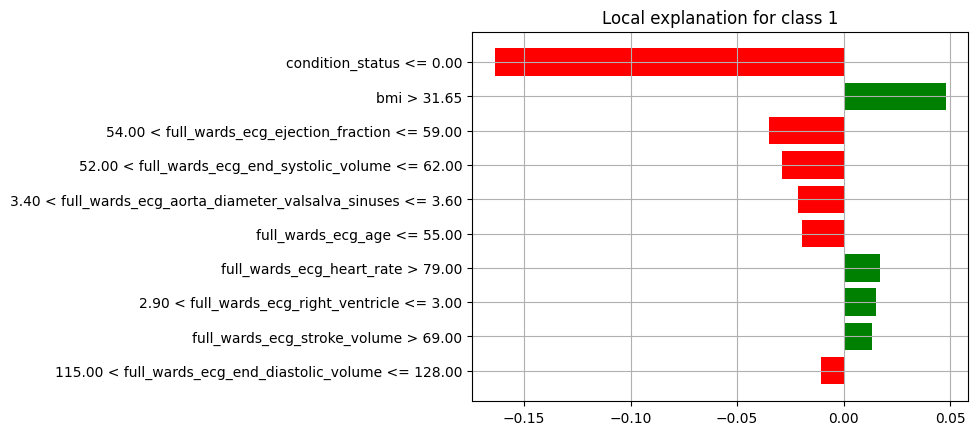

In [ ]:
import lime

import lime.lime_tabular

# Initialize the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.to_pandas().values,
    feature_names=X_train.columns,
    class_names=["0", "1"],
    mode="classification",
)


def lime_predict_fn(x):
    # x is a numpy array, shape (n, features)
    # Convert to DataFrame with correct columns and dtypes
    df = pd.DataFrame(x, columns=X_train.columns)
    # If you have categorical columns, cast them to the correct dtype
    for col in discrete_cols_cut:
        df[col] = df[col].astype(X_train[col].to_pandas().dtype)
    return model.predict_proba(df)


def explain_instance(instance, model, num_features=10):
    explanation = explainer.explain_instance(
        data_row=instance.values,
        predict_fn=lime_predict_fn,
        # num_features=num_features,
    )
    return explanation


# Example usage: Explain the first instance in the test set
instance_to_explain = X_test.to_pandas().iloc[3]
explanation = explain_instance(instance_to_explain, model)
fig = explanation.as_pyplot_figure()
plt.grid()
fig.show()

### random forest

In [ ]:
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 200, 800, step=100)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    #     criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])

    # Train the Random Forest model with the suggested hyperparameters
    rf_model = RandomForestClassifier(
        random_state=2024,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        #         criterion=criterion,
        n_jobs=-1,
    )
    rf_model.fit(X_train, y_train.to_pandas())

    # Evaluate the model
    y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
    auc_score_rf = roc_auc_score(y_test.to_pandas(), y_pred_proba_rf)

    return auc_score_rf


# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Print the best hyperparameters and the corresponding AUC score
print("Best hyperparameters:", study.best_params)
print("Best AUC score:", study.best_value)

[I 2025-06-07 11:43:23,297] A new study created in memory with name: no-name-5fd8bf48-6acd-4bab-ab9a-3fb9ca784676
[I 2025-06-07 11:43:23,854] Trial 0 finished with value: 0.7948012232415902 and parameters: {'n_estimators': 400, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7948012232415902.
[I 2025-06-07 11:43:24,578] Trial 1 finished with value: 0.7953109072375127 and parameters: {'n_estimators': 600, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.7953109072375127.
[I 2025-06-07 11:43:25,408] Trial 2 finished with value: 0.7982670744138632 and parameters: {'n_estimators': 800, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.7982670744138632.
[I 2025-06-07 11:43:26,145] Trial 3 finished with value: 0.7985728848114169 and parameters: {'n_estimators': 700, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.

Best hyperparameters: {'n_estimators': 500, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 2}
Best AUC score: 0.7998980632008156


In [155]:
study.best_params

{'n_estimators': 500,
 'max_depth': 8,
 'min_samples_split': 3,
 'min_samples_leaf': 2}

In [ ]:
# Train Random Forest model
rf_model = RandomForestClassifier(
    random_state=2024,
    n_estimators=500,
    max_depth=5,
    # **study.best_params,
)  # You can adjust hyperparameters as needed
rf_model.fit(X_train, y_train.to_pandas())

# Evaluate the model
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
auc_score_rf = roc_auc_score(y_test.to_pandas(), y_pred_proba_rf)

print(f"AUC Score (Random Forest): {auc_score_rf:.3f}")

AUC Score (Random Forest): 0.793


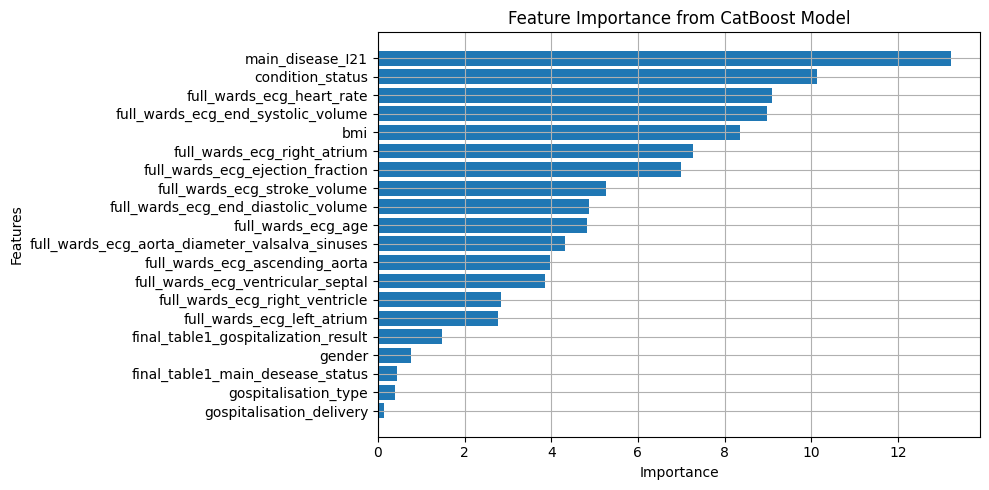

In [158]:
feature_importance = pd.DataFrame(
    {"feature": X_train.columns, "importance": model.feature_importances_}
).sort_values("importance", ascending=True)

plt.figure(figsize=(10, 5))
plt.barh(
    feature_importance["feature"],
    feature_importance["importance"],
)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance from CatBoost Model")
plt.tight_layout()
plt.grid()
plt.show()

### linear regression

In [159]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = X_train.with_columns(
    [c(col).cast(pl.Float64) for col in numerical_cols]
)
# X_eval_scaled = X_eval.with_columns([c(col).cast(pl.Float64) for col in numerical_cols])
X_test_scaled = X_test.with_columns([c(col).cast(pl.Float64) for col in numerical_cols])

X_train_scaled_pd = pd.DataFrame(
    scaler.fit_transform(X_train_scaled.select(numerical_cols).to_pandas()),
    columns=numerical_cols,
)
# X_eval_scaled_pd = pd.DataFrame(
#     scaler.transform(X_eval_scaled.select(numerical_cols).to_pandas()),
#     columns=numerical_cols,
# )
X_test_scaled_pd = pd.DataFrame(
    scaler.transform(X_test_scaled.select(numerical_cols).to_pandas()),
    columns=numerical_cols,
)

X_train_pd = X_train.to_pandas().drop(columns=numerical_cols)
# X_eval_pd = X_eval.to_pandas().drop(columns=numerical_cols)
X_test_pd = X_test.to_pandas().drop(columns=numerical_cols)

X_train_scaled_final = pd.concat([X_train_scaled_pd, X_train_pd], axis=1)
# X_eval_scaled_final = pd.concat([X_eval_scaled_pd, X_eval_pd], axis=1)
X_test_scaled_final = pd.concat([X_test_scaled_pd, X_test_pd], axis=1)


# Train Logistic Regression model
logistic_model = LogisticRegression(
    random_state=2024,
    solver="liblinear",
    penalty="l1",
)
logistic_model.fit(X_train_scaled_final, y_train.to_pandas())

# Evaluate the model
y_pred_proba = logistic_model.predict_proba(X_test_scaled_final)[:, 1]
auc_score = roc_auc_score(y_test.to_pandas(), y_pred_proba)

print(f"AUC Score: {auc_score:.3f}")

AUC Score: 0.803


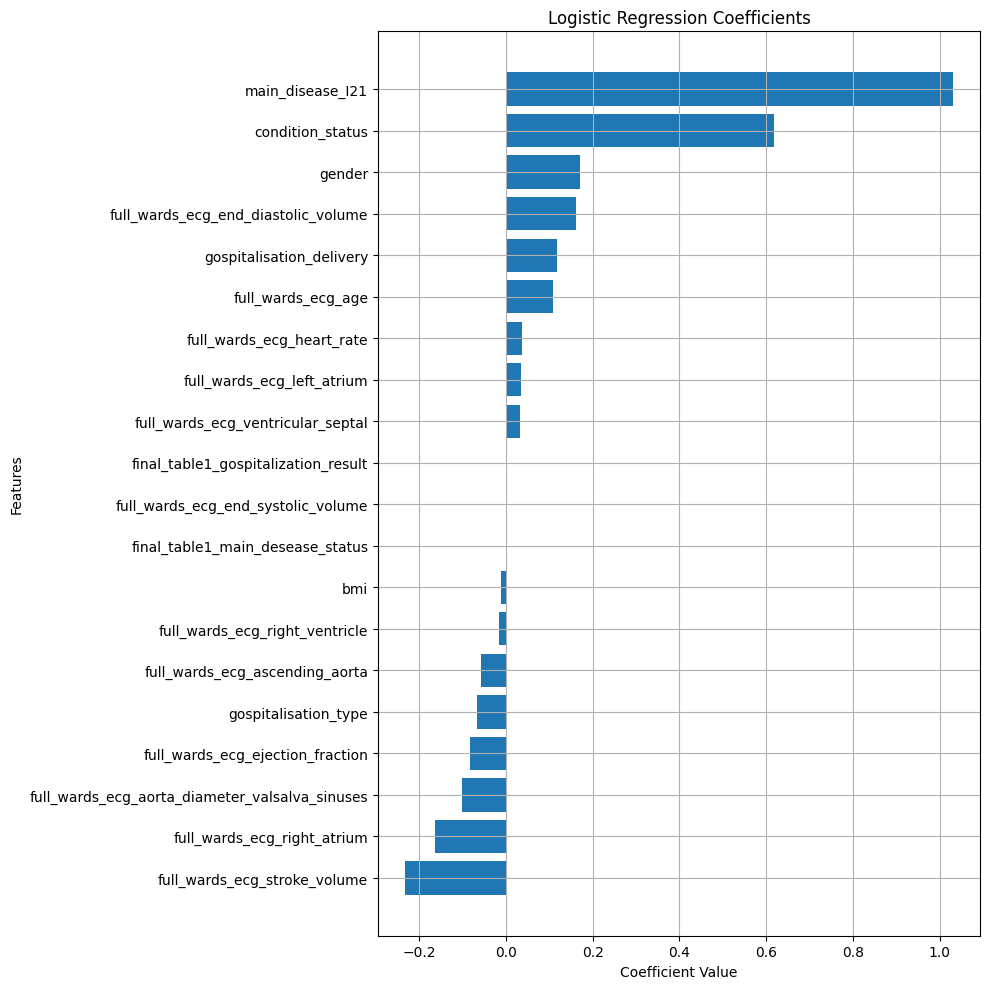

In [161]:
coefficients = pd.DataFrame(
    {
        "feature": X_train_scaled_final.columns,
        "coefficient": logistic_model.coef_[0],
    }
).sort_values("coefficient", ascending=True)

plt.figure(figsize=(10, 10))
plt.barh(
    coefficients["feature"],
    coefficients["coefficient"],
)
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.title("Logistic Regression Coefficients")
plt.tight_layout()
plt.grid()
plt.show()

### individual feature

In [133]:
roc_auc_score(y_test.to_pandas(), X_test["main_disease_I21"].to_pandas())

np.float64(0.7116717635066259)

## end